In [21]:
# tensorflow implementation of the projection shit
# make a full flow of the dataset and multiply accordingly, in the input section just put in the augmented matrix and 
# then projected volume inside the CNN. And then just hope for the best. TADA
#!/usr/bin/env python
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import visvis as vv

import os
import glob
import pyexr
import json
import OpenEXR
from numpy.linalg import inv
import imageio
imageio.plugins.freeimage.download()
try:
    to_unicode = unicode
except NameError:
    to_unicode = str

In [22]:
v = np.ones((100,100,3))
b = np.zeros((100,100,3))
c = np.ones((100,100,3))
v = np.concatenate((v,b),axis=-1)
print np.shape(v)
v = np.concatenate((v,c),axis=-1) 

print np.shape(v)

k=v[:,:,3:]
print np.shape(k)

(100, 100, 6)
(100, 100, 9)
(100, 100, 6)


In [23]:
#tensorpack implementation of the projection voxels



--Return--
> <ipython-input-98-12d72ef554ea>(58)<module>()->None
-> import pdb; pdb.set_trace()


KeyboardInterrupt: 

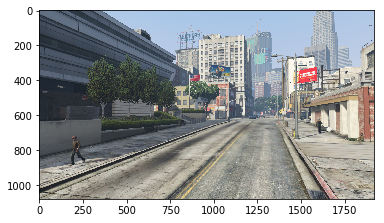

In [98]:
ref_depth_file = "/home/mallick/3D_project/MVS_stuckler/MVS_test/depths/0000.exr"
ref_image_file = "/home/mallick/3D_project/MVS_stuckler/MVS_test/images/0000.png"

nei_depth_file = "/home/mallick/3D_project/MVS_stuckler/MVS_test/depths/0003.exr"
nei_image_file = "/home/mallick/3D_project/MVS_stuckler/MVS_test/images/0003.png"


#step 1 : read pose matrix of reference and neighbour
with open('/home/mallick/3D_project/MVS_stuckler/MVS_test/poses/0000.json') as json_data:
    d = json.load(json_data)
r_info = d
r_c_x = r_info["c_x"]
r_c_y = r_info["c_y"]
r_f_x = r_info["f_x"]
r_f_y = r_info["f_y"]
r_extrinsic = np.array(r_info["extrinsic"])

with open('/home/mallick/3D_project/MVS_stuckler/MVS_test/poses/0003.json') as json_data:
    d = json.load(json_data)
n_info = d
n_c_x = n_info["c_x"]
n_c_y = n_info["c_y"]
n_f_x = n_info["f_x"]
n_f_y = n_info["f_y"]
n_extrinsic = np.array(n_info["extrinsic"])


#step 2 : continued later
# check pixels per metres, in my computer screen, it is http://lcdtech.info/en/data/pixel.size.htm = 0.000216
# formula 2.9 from the thesis page 9
scale_y = scale_x = 1
f = (r_f_x + r_f_y)/2

## read the images ##
ref_img = mpimg.imread(ref_image_file)
ref_depth = pyexr.read(ref_depth_file)  
nei_img = mpimg.imread(nei_image_file)
nei_depth = pyexr.read(nei_depth_file) 

shape_re = np.shape(ref_depth) # 1080,1920,1

#show the image
ref_img[1079,1919,0]
imgplot = plt.imshow(ref_img)


v = np.zeros(shape_re[0])
u = np.zeros(shape_re[1])
inv_depth=np.zeros((1080,1920))
p_c = np.zeros((1080,1920))
p_w = np.zeros((1080,1920))
y_proj = np.zeros(shape_re[0]) #1080
x_proj = np.zeros(shape_re[1]) #1920
projected_image = np.zeros((1080,1921,3))

x_r = 0
y_r = 0
import pdb; pdb.set_trace()


for x_r in xrange(shape_re[1]):
    for y_r in xrange(shape_re[0]):
        #step a: convert to IPCS from ICS
        v[y_r] = scale_y*(y_r - r_c_y)
        u[x_r] = scale_x*(x_r - r_c_x)
        #v[y_r] = (y_r - r_c_y)
        #u[x_r] = (x_r - r_c_x)
        #step b: convert to CCS from IPCS
        if ref_depth[y_r,x_r]>100000:
            ref_depth[y_r,x_r]=100000
        
        #import pdb; pdb.set_trace()
        
        ic=inv_depth[y_r,x_r] = 1/ref_depth[y_r,x_r,0]
        #z_c = 1
        #ic=1/z_c
        x_c = (u[x_r]/(f*ic))
        y_c = (v[y_r]/(f*ic))
        z_c = ref_depth[y_r,x_r,0]
        
        #step c: CCS to world
        # step 4 : project to world coordinate equation 2.13
        p_c = np.array([x_c,y_c,z_c, 1.0])
        #p_w = r_extrinsic.dot(p_c)
        p_w = np.matmul(inv(r_extrinsic),np.transpose(p_c))
        #step 5 : find pc from world
        #p_c_n = inv(n_extrinsic).dot(p_w)
        p_c_n = np.matmul((n_extrinsic),np.transpose(p_w)) # check with n_extrinsic
        p_c_n
        #world to ccs
        x_c_n= p_c_n[0]
        y_c_n= p_c_n[1]
        z_c_n= p_c_n[2]
        
        #ccs to ICS
        u_n = (f/z_c_n)*x_c_n
        v_n = (f/z_c_n)*y_c_n
        
        #ICS to IPCS
        y_proj[y_r] = np.ceil((v_n/scale_y) + n_c_y)
        x_proj[x_r] = np.ceil((u_n/scale_x) + n_c_x)
        
        #y_proj[y_r] = np.ceil((v_n/1) + n_c_y)
        #x_proj[x_r] = np.ceil((u_n/1) + n_c_x)
        if x_r>1919 or y_r>1079:
            print 'something is wrong'
        #print x_r, x_proj[x_r],y_r,y_proj[y_r]
        if ((x_proj[x_r].astype(int) > 1919) or (y_proj[y_r].astype(int) > 1079)):
            #print x_r, np.shape(x_proj),y_r,np.shape(y_proj)
            #projected_image[y_r,x_r,:] = 0
            y_proj[y_r]=1079
            x_proj[x_r]=1919
            
        elif ((x_proj[x_r].astype(int) < 0) or (y_proj[y_r].astype(int) < 0)):
            y_proj[y_r]=0
            #print y_r
            x_proj[x_r]=0
            #print x_r
        else:
            #projected_image[y_r,x_r,:]=ref_img[y_proj[y_r].astype(int),x_proj[x_r].astype(int),:]
            projected_image[y_proj[y_r].astype(int),x_proj[x_r].astype(int),:]=ref_img[y_r,x_r,:]
            #import pdb; pdb.set_trace()
        
        #projected_image[y_r,x_r,:]=ref_img[y_proj[y_r].astype(int),x_proj[x_r].astype(int),:]
       


In [25]:
ref_img = tf.convert_to_tensor(mpimg.imread(ref_image_file), dtype=tf.float32)
ref_depth = tf.convert_to_tensor(pyexr.read(ref_depth_file), dtype=tf.float32)
nei_img = tf.convert_to_tensor(mpimg.imread(nei_image_file), dtype=tf.float32)
nei_depth = tf.convert_to_tensor( pyexr.read(nei_depth_file), dtype=tf.float32)

In [34]:
'''
v = tf.Variable(tf.zeros([shape_re[0]], tf.float32))
u = tf.Variable(tf.zeros([shape_re[1]], tf.float32))
inv_depth=tf.Variable(tf.zeros([shape_re[0], shape_re[1]], tf.float32))
p_c = tf.Variable(tf.zeros([shape_re[0], shape_re[1]], tf.float32))
p_w = tf.Variable(tf.zeros([shape_re[0], shape_re[1]], tf.float32))
y_proj = tf.Variable(tf.zeros([shape_re[0]], tf.float32)) #1080 
x_proj = tf.Variable(tf.zeros([shape_re[1]], tf.float32)) #1920
projected_image = tf.Variable(tf.zeros([shape_re[0], shape_re[1],shape_re[2]], tf.float32))

x_r = 0
y_r = 0

for x_r in xrange(shape_re[1]):
    for y_r in xrange(shape_re[0]):
        #step a: convert to IPCS from ICS
        v=v[y_r].assign(scale_y*(y_r - r_c_y))
        u=u[x_r].assign(scale_x*(x_r - r_c_x))
'''

'\nv = tf.Variable(tf.zeros([shape_re[0]], tf.float32))\nu = tf.Variable(tf.zeros([shape_re[1]], tf.float32))\ninv_depth=tf.Variable(tf.zeros([shape_re[0], shape_re[1]], tf.float32))\np_c = tf.Variable(tf.zeros([shape_re[0], shape_re[1]], tf.float32))\np_w = tf.Variable(tf.zeros([shape_re[0], shape_re[1]], tf.float32))\ny_proj = tf.Variable(tf.zeros([shape_re[0]], tf.float32)) #1080 \nx_proj = tf.Variable(tf.zeros([shape_re[1]], tf.float32)) #1920\nprojected_image = tf.Variable(tf.zeros([shape_re[0], shape_re[1],shape_re[2]], tf.float32))\n'

In [ ]:
for x_r in xrange(5):
    for y_r in xrange(5):
        #step a: convert to IPCS from ICS
        V = tf.convert_to_tensor(scale_y*(y_r - r_c_y),tf.float32)
        U = tf.convert_to_tensor(scale_x*(x_r - r_c_x),tf.float32)
        if ref_depth[y_r,x_r]>100000:
            ref_depth[y_r,x_r]=100000
        
        #import pdb; pdb.set_trace()
        
        ic=inv_depth[y_r,x_r] = 1/ref_depth[y_r,x_r,0]
        #z_c = 1
        #ic=1/z_c
        x_c = (U/(f*ic))
        y_c = (V/(f*ic))
        z_c = tf.convert_to_tensor(ref_depth[y_r,x_r,0])
        
        p_c = tf.expand_dims((tf.stack([x_c,y_c,z_c,1.0])),0) #tf.stack([x, y, z])
        
        
        #p_w = r_extrinsic.dot(p_c)
        pc_tf = tf.matrix_inverse(tf.convert_to_tensor((r_extrinsic),tf.float32))
        #print np.shape(pc_tf)
        #print np.shape(p_c)
        p_w = tf.matmul(pc_tf,tf.transpose(p_c))
        #print np.shape(p_w)   
        
        pcn_tf=tf.convert_to_tensor((n_extrinsic),tf.float32)
        p_c_n = tf.matmul(pcn_tf,(p_w)) # check with n_extrinsic
        p_c_n
        #world to ccs
        x_c_n= p_c_n[0]
        y_c_n= p_c_n[1]
        z_c_n= p_c_n[2]
        
        #ccs to ICS
        u_n = (f/z_c_n)*x_c_n
        v_n = (f/z_c_n)*y_c_n
        
        #ICS to IPCS
        xx_proj = tf.ceil((v_n/scale_y) + n_c_y)
        yy_proj = tf.ceil((u_n/scale_x) + n_c_x)
        with tf.Session() as session:
            
            if ((X_proj.astype(int) > 1919) or (Y_proj.astype(int) > 1079)):
                #print x_r, np.shape(x_proj),y_r,np.shape(y_proj)
                #projected_image[y_r,x_r,:] = 0
                X_proj=1079
                Y_proj=1919

            elif ((X_proj.astype(int) < 0) or (Y_proj.astype(int) < 0)):
                Y_proj=0
                #print y_r
                X_proj=0
                #print x_r
            else:
                #projected_image[y_r,x_r,:]=ref_img[y_proj[y_r].astype(int),x_proj[x_r].astype(int),:]
                projected_image[Y_proj.astype(int),X_proj.astype(int),:]=ref_img[y_r,x_r,:]



In [33]:


aa=tf.Variable(tf.zeros(3, tf.int32))
aa=aa[2].assign(1)


In [89]:
#step 1 : read pose matrix of reference and neighbour
with open('/home/mallick/3D_project/MVS_stuckler/MVS_test/poses/0000.json') as json_data:
    d = json.load(json_data)
r_info = d
r_c_x = r_info["c_x"]
r_c_y = r_info["c_y"]
r_f_x = r_info["f_x"]
r_f_y = r_info["f_y"]
r_extrinsic = np.array(r_info["extrinsic"])

In [94]:
pose = np.zeros((4,5))
print pose
r_extrinsic

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


array([[ 2.91222567e-01, -9.56658393e-01, -1.10509806e-06,
         1.04685063e+04],
       [ 4.21499240e-02,  1.28315749e-02,  9.99027809e-01,
         3.80314061e+02],
       [ 9.55720373e-01,  2.90946996e-01, -4.40592011e-02,
         1.72045835e+03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [96]:
pose[:4,:4] = r_extrinsic
pose[0,4] = r_c_x
pose[1, 4] = r_c_y
pose[2, 4] = r_f_x
pose[3, 4] = r_f_y
print pose

[[ 2.91222567e-01 -9.56658393e-01 -1.10509806e-06  1.04685063e+04
   9.60000000e+02]
 [ 4.21499240e-02  1.28315749e-02  9.99027809e-01  3.80314061e+02
   5.40000000e+02]
 [ 9.55720373e-01  2.90946996e-01 -4.40592011e-02  1.72045835e+03
   1.15784739e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
   1.15784100e+03]]


In [99]:
import tensorflow as tf
x = tf.Variable([1.0, 2.0])
x = tf.Print(x,[x])
x = 2* x

In [102]:
tf.global_variables_initializer
v = x.eval()
print(v)

ValueError: Cannot evaluate tensor using `eval()`: No default session is registered. Use `with sess.as_default()` or pass an explicit session to `eval(session=sess)`